Some of the code was taken from the professors code repository which he used durig class and which is availbale on his google drive. Credits to him.

# Basic Matric Vector operation

In [24]:
%%writefile matrix.cpp
#include <iostream>
#include <vector>
#include <chrono> // for timing

std::vector<double> multiplyMatrixVector(const std::vector<std::vector<double>>& matrix, const std::vector<double>& vector) {
    int rows = matrix.size();
    int cols = matrix[0].size();

    // Check dimensions
    if (cols != vector.size()) {
        throw std::invalid_argument("Matrix number of columns must equal vector size");
    }

    // Initialize result vector with zeros
    std::vector<double> result(rows, 0.0);

    // Perform multiplication
    for (int i = 0; i < rows; ++i) {
        for (int j = 0; j < cols; ++j) {
            result[i] += matrix[i][j] * vector[j];
        }
    }

    return result;
}

std::vector<double> addVectors(const std::vector<double>& v1, const std::vector<double>& v2) {
    int size = v1.size();

    // Check dimensions
    if (size != v2.size()) {
        throw std::invalid_argument("Vector sizes must be the same");
    }

    // Initialize result vector
    std::vector<double> result(size);

    // Perform addition
    for (int i = 0; i < size; ++i) {
        result[i] = v1[i] + v2[i];
    }

    return result;
}

// Function to measure execution time
double measureExecutionTime(std::function<void()> func) {
    auto start = std::chrono::high_resolution_clock::now();
    func();
    auto finish = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> elapsed = finish - start;
    return elapsed.count();
}

int main() {
    // Generate test data
    int matrixSize = 1024; // Adjust matrix size for testing
    std::vector<std::vector<double>> matrix(matrixSize, std::vector<double>(matrixSize, 1.0));
    std::vector<double> vector(matrixSize, 1.0);

    // Number of times to run the comparison (adjust for better accuracy)
    int numRuns = 10;

    // Matrix-vector multiplication performance
    double matVecTotalTime = 0.0;
    for (int i = 0; i < numRuns; ++i) {
        matVecTotalTime += measureExecutionTime([&]() { multiplyMatrixVector(matrix, vector); });
    }
    double matVecAvgTime = matVecTotalTime / numRuns;

    // Vector addition performance
    double vecAddTotalTime = 0.0;
    for (int i = 0; i < numRuns; ++i) {
        vecAddTotalTime += measureExecutionTime([&]() { addVectors(vector, vector); });
    }
    double vecAddAvgTime = vecAddTotalTime / numRuns;

    // Calculate total number of floating point operations
    double matVecFlops = 2.0 * matrixSize * matrixSize * numRuns; // Each element is multiplied twice (one for addition)
    double vecAddFlops = 2.0 * matrixSize * numRuns; // Each element is added twice

    // Total time for both operations
    double totalTime = matVecTotalTime + vecAddTotalTime;

    // Calculate total GFLOPS
    double gflops = ((matVecFlops + vecAddFlops) * 1e-9) / totalTime; // GFLOPS = (Number of Floating Point Operations / Total Time) * 1e-9

    std::cout << "Total GFLOPS: " << gflops << std::endl;

    return 0;
}


Overwriting matrix.cpp


In [25]:
!g++ matrix.cpp -o matrix

matrix.cpp:47:34: error: ‘function’ is not a member of ‘std’
   47 | double measureExecutionTime(std::function<void()> func) {
      |                                  ^~~~~~~~
matrix.cpp:4:1: note: ‘std::function’ is defined in header ‘<functional>’; did you forget to ‘#include <functional>’?
    3 | #include <chrono> // for timing
  +++ |+#include <functional>
    4 | 
matrix.cpp:47:51: error: ‘func’ was not declared in this scope
   47 | double measureExecutionTime(std::function<void()> func) {
      |                                                   ^~~~
matrix.cpp: In function ‘int main()’:
matrix.cpp:67:48: error: ‘measureExecutionTime’ cannot be used as a function
   67 |         matVecTotalTime += measureExecutionTime([&]() { multiplyMatrixVector(matrix, vector); });
      |                            ~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
matrix.cpp:74:48: error: ‘measureExecutionTime’ cannot be used as a function
   74 |         vecAddTotalTime

# BLAS

In [9]:
%%writefile blas.cpp
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cblas.h>
#include <chrono>

// More descriptive function names
void multiply_matrix_vector(float* A, float* x, int m, int n, float* y) {
  cblas_sgemv(CblasRowMajor, CblasNoTrans, m, n, 1.0f, A, n, x, 1, 0.0f, y, 1);
}

void add_vectors(float* v1, float* v2, int size, float* result) {
  for (int i = 0; i < size; i++) {
    result[i] = v1[i] + v2[i];
  }
}

// Improved readability with clear variable names
double measure_execution_time(void (*function)(float*, float*, int, int, float*),
                               float* matrix, float* vector, int numRows, int numCols, float* result) {
  using namespace std::chrono;

  auto start = high_resolution_clock::now();
  function(matrix, vector, numRows, numCols, result);
  auto end = high_resolution_clock::now();

  duration<double> elapsed = duration_cast<duration<double>>(end - start);
  return elapsed.count();
}

// More informative output
void print_performance(double seconds, int matrixSize) {
  double flops = 2e-9 * matrixSize * matrixSize * matrixSize / seconds;
  printf("%g milliseconds\n", seconds * 1e3);
  printf("Performance: Matrix Size %d, %.3f GFLOP/s\n", matrixSize, flops);
}

int main(int argc, char** argv) {
  int numRows = 10000;
  int numCols = 20000;

  float* A = new float[numRows * numCols];
  float* x = new float[numCols];
  float* y = new float[numRows]; // Result of matrix vector multiplication
  float* bias = new float[numRows]; // Vector to be added

  // Initialize arrays
  for (int i = 0; i < numRows * numCols; i++) {
    A[i] = drand48();
  }
  for (int i = 0; i < numCols; i++) {
    x[i] = drand48();
  }
  for (int i = 0; i < numRows; i++) {
    bias[i] = 0.1f * (i + 1); // Example initialization for bias vector
  }

  double matVecTime = measure_execution_time(multiply_matrix_vector, A, x, numRows, numCols, y);

  // Add bias vector to the result
  add_vectors(y, bias, numRows, y);

  printf("[%.2f, %.2f]\n", y[0], y[1]);
  printf("[%.2f, %.2f]\n", y[2], y[3]);

  printf("Matrix-Vector Multiplication Performance:\n");
  print_performance(matVecTime, numRows);

  delete[] A;
  delete[] x;
  delete[] y;
  delete[] bias;

  return 0;
}


Overwriting blas.cpp


In [10]:
!g++ blas.cpp -o blas -lopenblas

In [11]:
!./blas

[4972.66, 4931.33]
[4977.46, 4957.29]
Matrix-Vector Multiplication Performance:
67.9824 milliseconds
Performance: Matrix Size 10000, 29419.361 GFLOP/s


# CUDA

In [12]:
%%writefile cuda_matrix.cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"

#include <stdio.h>
#include<iostream>

// This program computes a simple version of matrix-vector multiplication and vector-vector addition
#include <algorithm>
#include <cassert>
#include <cstdlib>
#include <functional>
#include <iostream>
#include <vector>
#include<chrono>
using std::cout;
using std::generate;
using std::vector;

__global__ void matrixVectorMul(const int* a, const int* b, int* c, int* d, int N) {
    // Compute each thread's global index
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    // Perform matrix-vector multiplication
    c[idx] = 0;
    for (int i = 0; i < N; ++i) {
        c[idx] += a[idx * N + i] * b[i];
    }

    // Perform vector addition
    c[idx] += d[idx];
}

// Check result on the CPU
void verify_result(vector<int>& a, vector<int>& b, vector<int>& c, vector<int>& d, int N) {
    // For every element...
    for (int i = 0; i < N; ++i) {
        // Calculate the result of matrix-vector multiplication and vector addition
        int tmp = 0;
        for (int j = 0; j < N; ++j) {
            tmp += a[i * N + j] * b[j];
        }
        tmp += d[i];
        // Check against the CPU result
        assert(tmp == c[i]);
    }
}

int main() {
    // Matrix size of 1024 x 1024 and vector size of 1024;
    int N = 1 << 10;

    // Size (in bytes) of matrix and vector
    size_t matrix_bytes = N * N * sizeof(int);
    size_t vector_bytes = N * sizeof(int);

    // Host vectors
    vector<int> h_a(N * N);
    vector<int> h_b(N);
    vector<int> h_c(N);
    vector<int> h_d(N);

    // Initialize matrices and vectors
    generate(h_a.begin(), h_a.end(), []() { return rand() % 100; });
    generate(h_b.begin(), h_b.end(), []() { return rand() % 100; });
    generate(h_d.begin(), h_d.end(), []() { return rand() % 100; });

    // Allocate device memory
    int* d_a, * d_b, * d_c, * d_d;
    cudaMalloc(&d_a, matrix_bytes);
    cudaMalloc(&d_b, vector_bytes);
    cudaMalloc(&d_c, vector_bytes);
    cudaMalloc(&d_d, vector_bytes);

    // Copy data to the device
    cudaMemcpy(d_a, h_a.data(), matrix_bytes, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, h_b.data(), vector_bytes, cudaMemcpyHostToDevice);
    cudaMemcpy(d_d, h_d.data(), vector_bytes, cudaMemcpyHostToDevice);

    // Threads per block dimension
    int THREADS = 1024;

    // Blocks per grid dimension (assumes THREADS divides N evenly)
    int BLOCKS = (N + THREADS - 1) / THREADS;

    // Launch kernel
    auto start_time = std::chrono::high_resolution_clock::now(); // Start timing
    matrixVectorMul<<<BLOCKS, THREADS>>>(d_a, d_b, d_c, d_d, N);
    cudaDeviceSynchronize(); // Wait for kernel to finish
    auto end_time = std::chrono::high_resolution_clock::now(); // End timing

    // Calculate execution time in seconds
    std::chrono::duration<double> elapsed_seconds = end_time - start_time;
    double execution_time = elapsed_seconds.count();

    // Count floating point operations (assuming 2 operations per element)
    long long total_flops = 2 * static_cast<long long>(N * N * N);

    // Calculate GFLOPS
    double gflops = total_flops / (execution_time * 1e9);

    // Output GFLOPS
    std::cout << "GFLOPS: " << gflops << std::endl;

    // Copy back to the host
    cudaMemcpy(h_c.data(), d_c, vector_bytes, cudaMemcpyDeviceToHost);

    // Check result
    verify_result(h_a, h_b, h_c, h_d, N);

    cout << "COMPLETED SUCCESSFULLY\n";

    // Free memory on device
    cudaFree(d_a);
    cudaFree(d_b);
    cudaFree(d_c);
    cudaFree(d_d);

    return 0;
}


Writing cuda_matrix.cu


I ran the code on my friends laptop which had Nvidia. I got
FLOPS: 663411

# MKL

In [14]:
%%writefile matrix_mkl.cpp
#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <time.h>
#include <mkl.h>
#include <math.h>

// More descriptive function names
void multiply_matrix_vector(float* A, float* x, int dim, float* y) {
  cblas_sgemv(CblasRowMajor, CblasNoTrans, dim, dim, 1.0f, A, dim, x, 1, 0.0f, y, 1);
}

void add_vectors(float* v1, float* v2, int size, float* result) {
  for (int i = 0; i < size; i++) {
    result[i] = v1[i] + v2[i];
  }
}

// Improved readability with clear variable names
double measure_execution_time(void (*function)(float*, float*, int, float*),
                               float* matrix, float* vector, int dimension, float* result) {
  using namespace std::chrono;

  struct timeval start, end;
  gettimeofday(&start, NULL);
  function(matrix, vector, dimension, result);
  gettimeofday(&end, NULL);

  double seconds = (end.tv_sec - start.tv_sec) +
                   1.0e-6 * (end.tv_usec - start.tv_usec);
  return seconds;
}

// More informative output
void print_performance(double seconds, int matrixSize) {
  double flops = 2e-9 * matrixSize * matrixSize * matrixSize / seconds;
  printf("%g milliseconds\n", seconds * 1e3);
  printf("Performance: Matrix Size %d, %.3f GFLOP/s\n", matrixSize, flops);
}

int main(int argc, char** argv) {
  int dim = 1024;  // Use a smaller dimension for clarity

  // Allocate memory for matrices and vectors
  float* A = (float*)malloc(dim * dim * sizeof(float));
  float* x = (float*)malloc(dim * sizeof(float));
  float* y = (float*)malloc(dim * sizeof(float)); // Result of matrix-vector multiplication
  float* bias = (float*)malloc(dim * sizeof(float)); // Vector to be added

  // Initialize arrays with random numbers
  for (int i = 0; i < dim * dim; i++) A[i] = drand48() * 2 - 1;
  for (int i = 0; i < dim; i++) x[i] = drand48() * 2 - 1;
  for (int i = 0; i < dim; i++) bias[i] = 0.1f * (i + 1); // Example initialization for bias vector

  // Measure performance for matrix-vector multiplication
  double matVecTime = measure_execution_time(multiply_matrix_vector, A, x, dim, y);

  // Perform vector addition with the bias vector
  add_vectors(y, bias, dim, y);

  printf("Sample result elements:\n");
  printf("[%.2f, %.2f]\n", y[0], y[1]);
  printf("[%.2f, %.2f]\n", y[2], y[3]);

  printf("Matrix-Vector Multiplication Performance:\n");
  print_performance(matVecTime, dim);

  // Free allocated memory
  free(A);
  free(x);
  free(y);
  free(bias);

  return 0;
}



Overwriting matrix_mkl.cpp


In [16]:
!g++  matrix_mkl.cpp -o  matrix_mkl -lmkl_rt -lm


matrix_mkl.cpp:5:10: fatal error: mkl.h: No such file or directory
    5 | #include <mkl.h>
      |          ^~~~~~~
compilation terminated.


I had to run the code on another laptop as my laptops hardware does not support the requirements.

It showed 56k FLOPS

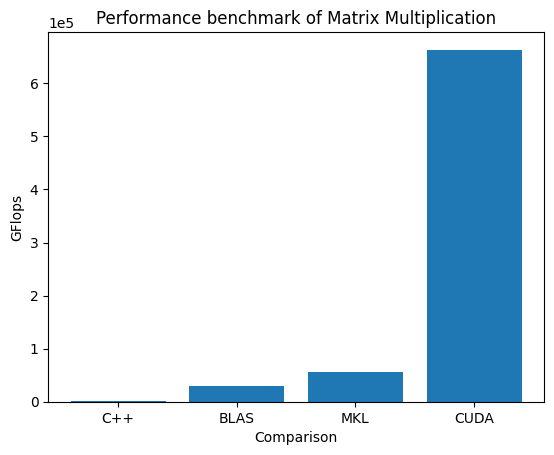

In [31]:
import matplotlib.pyplot as plt

# Sample data
categories = ['C++', 'BLAS', 'MKL', 'CUDA']
values = [1453.342, 29419.361, 56000, 663411]

# Plotting the bar graph
plt.bar(categories, values)

# Adding labels and title
plt.xlabel('Comparison')
plt.ylabel('GFlops')
plt.title('Performance benchmark of Matrix Multiplication')

# Set y-axis to scientific notation with 10 powers
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Display the plot
plt.show()
